Let's do this step by step. So first, let's see the environment, get a feeling of what is going on.

In [1]:
import matplotlib.pyplot as plt

In [11]:
import gymnasium as gym
import numpy as np
import time
import pygame
#----random policy----
policy  =lambda obs: np.random.randint(0,2)

BLUE = (0, 0, 255)
env = gym.make('CartPole-v1',render_mode = "human")
rewards =[]
for i in range(10):
    obs, info = env.reset()
    episode_reward = 0
    terminated = truncated = False
    while not terminated and not truncated:
        time.sleep(0.05)
        env.render()
        screen = pygame.display.set_mode((600, 400))
        action = policy(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        display_surface = pygame.display.get_surface()
        font = pygame.font.SysFont(None, 60)
        img = font.render('reward:'+str(episode_reward), True, BLUE)
        screen.blit(img, (10, 10))
        pygame.display.update()
    rewards.append(episode_reward)    
env.close()
        



Text(0.5, 1.0, 'random policy')

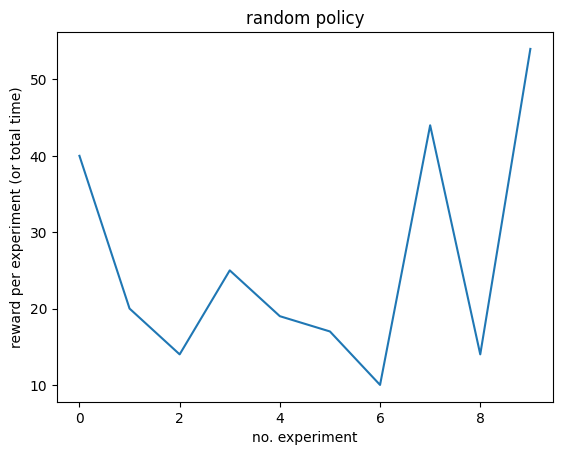

In [12]:
plt.plot([i for i in range(10)],rewards)
plt.xlabel('no. experiment')
plt.ylabel('reward per experiment (or total time)')
plt.title('random policy')

Nice, next step, let's bring RLlib into the game!

In [2]:
from ray.rllib.algorithms.ppo import PPO,PPOConfig
from ray.tune.logger import pretty_print

algo =  (PPOConfig()
        .resources(num_gpus=0) # i dont have gpu 
        .rollouts(num_rollout_workers=1) # with low memory, best use just one worker
        .environment(env="CartPole-v1") # ray has built in gymnasium envs
        .framework("torch") # tensorflow also available, but i installed torch so im using this one
        .build() # not sure what this does , yet
)

mean_ = []
min_= []
max_= []
episodes = []

for i in range(50):
    result = algo.train()
    mean_.append(result['episode_reward_mean'])
    min_.append(result['episode_reward_min'])
    max_.append(result['episode_reward_max'])
    episodes.append(result['episodes_total'])

Could not instantiate TBXLogger: No module named 'tensorboardX'.


Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-21 19:44:44,424	INFO worker.py:1555 -- Started a local Ray instance.
(RolloutWorker pid=17200) 2023-01-21 19:44:51,846	WARNING env.py:167 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=17200) 2023-01-21 19:44:51,903	INFO policy.py:1198 -- Policy (worker=1) running on CPU.
(RolloutWorker pid=17200) 2023-01-21 19:44:51,903	INFO torch_policy_v2.py:110 -- Found 0 visible cuda devices.
2023-01-21 19:44:51,986	INFO worker_set.py:310 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32), Discrete(2)), '__env__': (Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4

Text(0, 0.5, 'reward')

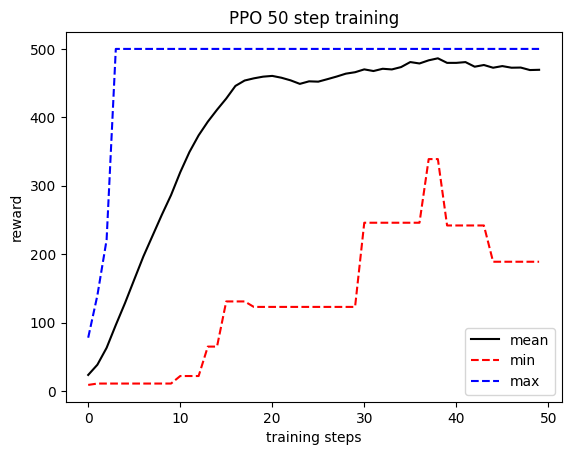

In [3]:
iters = [i for i in range(50)]
plt.plot(iters,mean_,color = 'black',label='mean')
plt.plot(iters,min_,ls='dashed',color='red',label='min')
plt.plot(iters,max_,ls='dashed',color='blue',label='max')
plt.xlabel('training steps')
plt.title('PPO 50 step training')
plt.legend()
plt.ylabel('reward')

In [ ]:
plt.plot(iters,episodes)
plt.xlabel('training steps')
plt.ylabel('# episodes')
plt.title('PPO training cartpole')

In [5]:
checkpoint_dir = algo.save('./model_2workers')

In [9]:
agent = PPOConfig().framework('torch').environment(env="CartPole-v1").build()
agent.restore(checkpoint_dir)

2023-01-21 20:10:59,208	INFO worker_set.py:310 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32), Discrete(2)), '__env__': (Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32), Discrete(2))}
2023-01-21 20:10:59,216	INFO policy.py:1198 -- Policy (worker=local) running on CPU.
2023-01-21 20:10:59,217	INFO torch_policy_v2.py:110 -- Found 0 visible cuda devices.
2023-01-21 20:10:59,228	INFO rollout_worker.py:2040 -- Built policy map: <PolicyMap lru-caching-capacity=100 policy-IDs=['default_policy']>
2023-01-21 20:10:59,230	INFO rollout_worker.py:2041 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x00000250FD4666C8>}
2023-01-21 20:10:59,231	INFO rollout_wo

In [ ]:
BLUE = (0, 0, 255)
env = gym.make('CartPole-v1',render_mode = "human")
rewards =[]
for i in range(10):
    obs, info = env.reset()
    episode_reward = 0
    terminated = truncated = False
    while not terminated and not truncated:
        time.sleep(0.05)
        env.render()
        screen = pygame.display.set_mode((600, 400))
        action = agent.compute_single_action(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        display_surface = pygame.display.get_surface()
        font = pygame.font.SysFont(None, 60)
        img = font.render('reward:'+str(episode_reward), True, BLUE)
        screen.blit(img, (10, 10))
        pygame.display.update()
    rewards.append(episode_reward)    
env.close()

Text(0.5, 1.0, 'PPO trained policy')

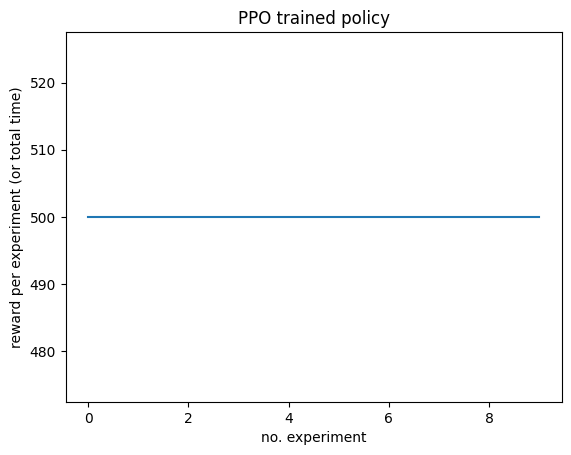

In [79]:
plt.plot([i for i in range(10)],rewards)
plt.xlabel('no. experiment')
plt.ylabel('reward per experiment (or total time)')
plt.title('PPO trained policy')